# Combinação de modelos - Parte 2 - Random Forest

1) Monte um passo a passo para o algoritmo `Random Forest`.

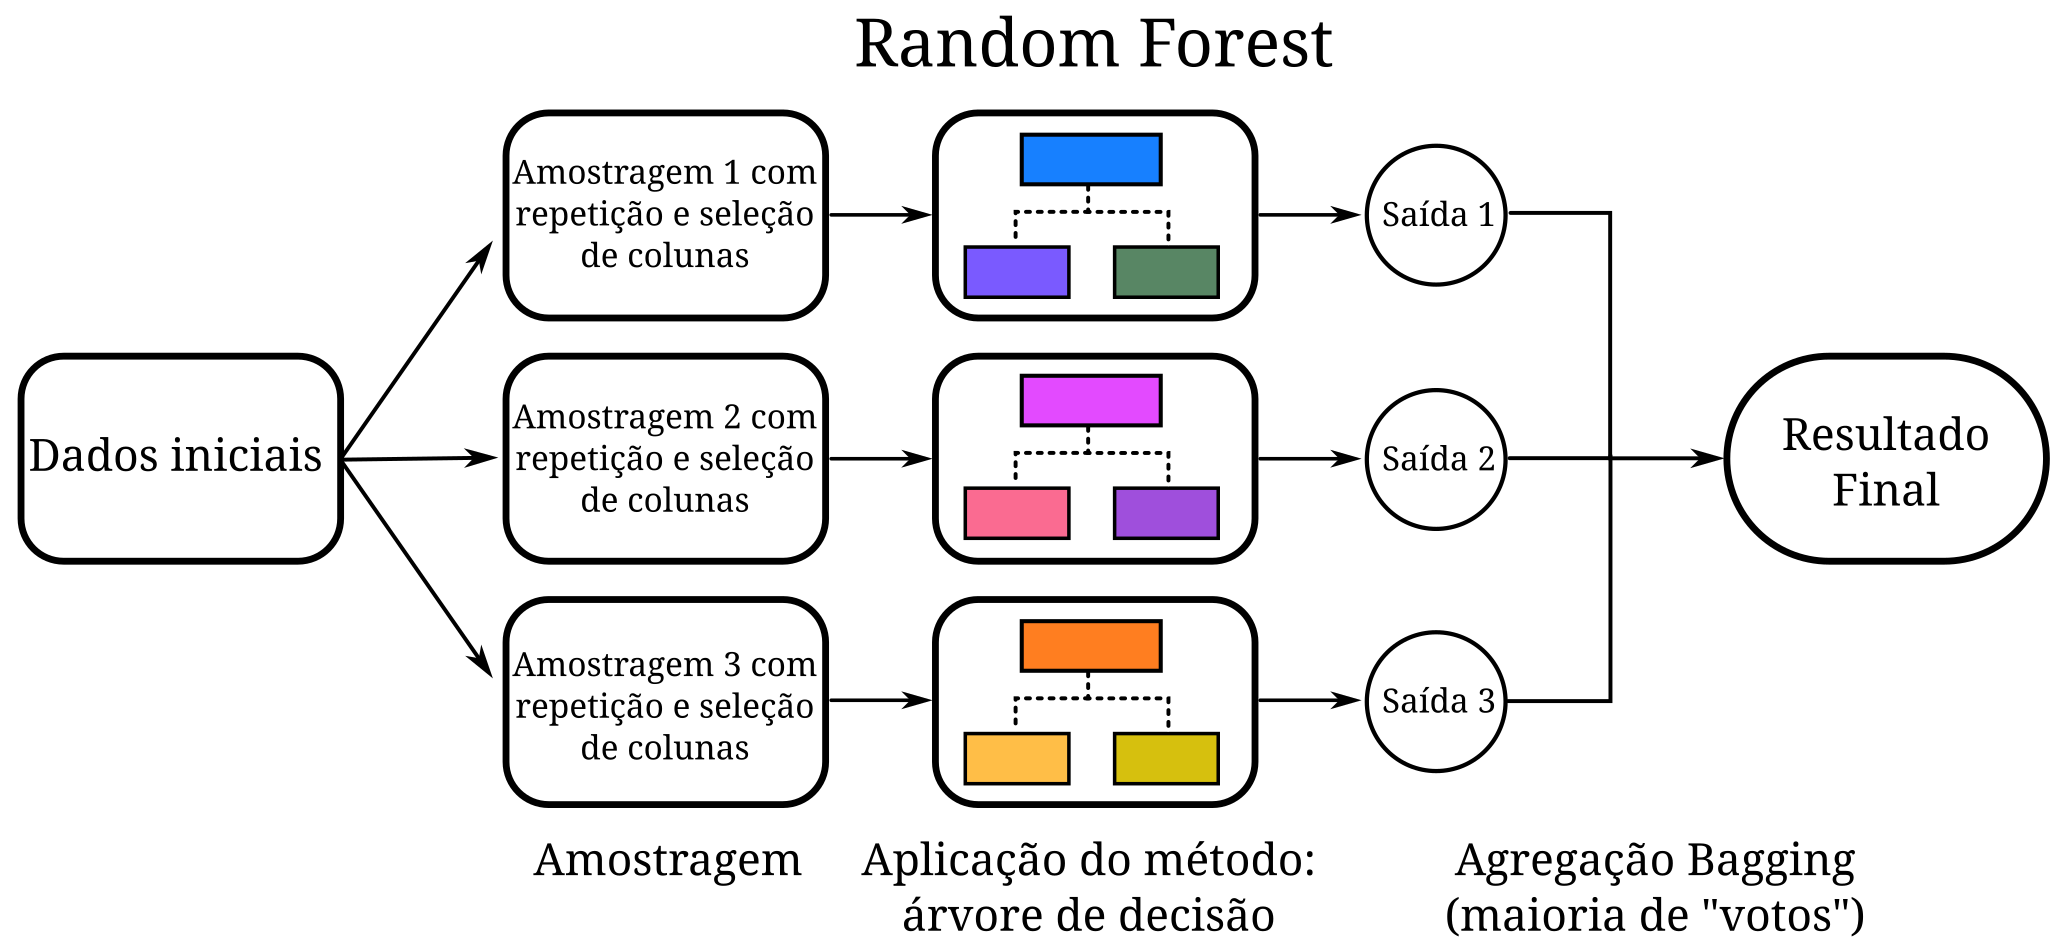

2) Entendimento da técnica (Random Forest):

Analogamente ao Bagging, o Random Forest também é composto por uma etapa de amostragem com repetição, porém nessa etapa há também uma seleção das colunas do conjunto de dados inicial, ou seja, cada amostra é composta por diferentes variáveis, reduzindo correlação dos dados e praticamente eliminando a possibilidade de overfitting. É sugerido que a seleção do número de colunas $m$ em cada agrupamento seja uma função do número de colunas $p$ do conjunto de dados e siga o seguinte padrão:
- Para classificação $ \rightarrow m= \sqrt(p) $
- Para regressão $ \rightarrow m=p/3$.

Na sequência temos o treinamento de modelos de árvore de decisão com os dados das amostras (cada amostragem irá alimentar um modelo) e, com as saídas desses modelos, faz-se uma agregação para definir o resultado final do Random Forest, assim como é feito pela técnica Bagging.

3. Qual a diferença entre Bagging e Random Forest?

A principal diferença está na forma com que a aleatoriedade é inserida na amostragem. O Random Forest utiliza o bootstrap e também feature selection (basicamente a seleção de colunas diferentes para cada amostra) e isso reduz a correlação entre os dados das amostras, gerando árvores menos correlacionadas e mais independentes. Isso também reduz drasticamente a possibilidade de overfitting do Random Forest.

4. Implementação em Python do Random Forest.

In [74]:
# bibliotecas 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from collections import Counter

import random

## Definindo a função Random Forest

Destacando que a função `Random_Forest()` possui os parâmetros:
- df --> DataFrame
- decision_model --> 'classifier' para modelo de classificação e 'regressor' para modelo de regressão
- samples --> `int`, número de amostras (amostragem com repetição)
- sample_size --> padrão `None`, define o tamanho da amostra em dimensão
- target_var --> padrão `None`, define a variável de interesse (variável resposta)


A função irá retornar: 
- Os valores previstos pelos modelos
- Os valores de previsão selecionados pelo `Random Forest`

In [77]:
def Random_Forest(df, decision_model='classifier', samples=5, sample_size= None, target_var=None):
    
    # Valores previstos
    valores_previstos = {}
    
    # Removendo os dados missing da variável de interesse (a serem previstos)
    df_treated = df[~df[target_var].isna()]

    # Amostras
    n_amostras = []
    for j, _ in enumerate(np.zeros(samples)):
        n_amostras.append(df_treated.sample(sample_size, replace=True))

    # Avaliando a quantidade de dados duplicados     
    for i, _ in enumerate(n_amostras):
        print('A quantidade de dados repetidos para a amostra {} é: '.format(i+1), _.duplicated().sum())
    print('############################################################\n')

    for i, amostra in enumerate(n_amostras):
        # Separando os dados em explicativos e target
        y = amostra[target_var]   
        x = pd.get_dummies(amostra.drop(columns=[target_var]), drop_first=False)
        
        # Filtrando as colunas (feature selection)
        # Adicionando os parâmetros para o feature selection
        p = x.columns.nunique() # Número de colunas no DataFrame
        m = None # Número de colunas a ser introduzido nas amostras        
        # Filtrando em função do modelo de decisão escolhido
        if decision_model == 'classifier':
            decision_model_selected = DecisionTreeClassifier
            m = int(round(np.sqrt(p), 0))
            print('--> Número de colunas da amostra', m)
        elif decision_model == 'regressor':
            decision_model_selected = DecisionTreeRegressor
            m = int(round((p/3), 0)) 
            print('--> Número de colunas da amostra', m)

        # Voltando para a seleção dos dados explicativos 
        x = x.sample(m, axis=1)
        print('--> As colunas selecionadas foram: ', list(x.columns))
        
        # Treino e teste
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.75, test_size=.25, random_state=100)
        
        # gerando árvore
        clf = decision_model_selected(random_state=100)
        path = clf.cost_complexity_pruning_path(x_train, y_train)
        ccp_alphas, impurities = path.ccp_alphas, path.impurities
        
        # Usando pós-poda
        clfs = []
        for ccp_alpha in ccp_alphas:
            clf = decision_model_selected(ccp_alpha=ccp_alpha, random_state=100)
            clf.fit(x_train, y_train)
            clfs.append(clf)

        # Verificando "pontuação" dos modelos
        train_score = [clf.score(x_train, y_train) for clf in clfs]
        test_score = [clf.score(x_test, y_test) for clf in clfs]
    
        # Selecionando o melhor índice e a melhor árvore
        indice_melhor_arvore = len(test_score) - test_score[::-1].index(max(test_score)) - 1
        print('--> Modelo {}'.format(i+1))
        print('--> Melhor índice:', indice_melhor_arvore)
        melhor_arvore = clfs[indice_melhor_arvore]
        print('--> Melhor árvore:',melhor_arvore)
        print('--> Score melhor árvore {}%'.format(melhor_arvore.score(x_test, y_test)*100))
        
        # Definindo os valores a serem substituídos (previstos)
        prever = pd.get_dummies(df.drop(columns=[target_var]), drop_first=False)
        # Ajustando com o feature selection
        prever = prever[list(x.columns)]
        prever_target = prever[df[target_var].isna()]
        
        # Fazendo a classificação conforme a árvore
        predicted_values = melhor_arvore.predict(prever_target)
        print('--> Valores preditos pelo modelo {}: {}'.format(i+1, predicted_values))
        print('--------------------------------------------------------------------\n')

        # Dicionário com os dados a serem substituídos

        valor = {'Modelo {}'.format(i+1): predicted_values}
        valores_previstos.update(valor)


    # Oganizando dados previstos em listas
    lista = []
    list_returned_model = list(valores_previstos.values())
    n_elements_list_returned_model = list(valores_previstos.values())[0]    
    for k in range(len(n_elements_list_returned_model)): 
        inner_list = []
        lista.append(inner_list)
        for l in range(len(list_returned_model)):
            line = list(valores_previstos.values())[l][k]
            inner_list.append(line)
    # print(lista)

    
    # Gerando saída final do Random Forest
    if decision_model == 'classifier':
        aggregation_values = []
        for _ in lista:
            contador = dict(Counter(_))
            selector = dict(sorted(contador.items()))
            lista_first_item = list(selector)[0]
            aggregation_values.append(lista_first_item) 
        aggregation_values
        
    elif decision_model == 'regressor':
        lista_avg = []
        for _ in lista:
            # print(_)
            avg = sum(_)/len(_)
            lista_avg.append(avg)
            # print(avg)
        lista_avg    
        aggregation_values = lista_avg 

    return valores_previstos, aggregation_values


# Função para retornar dataframe com os dados previstos adicionados
def imput_values_to_df(df, target_var=None, aggregation_output=None):
    df.loc[df[target_var].isna(), target_var] = aggregation_output
    return df

### Carregando dados para verificação da função em relação ao parâmetro `decision_model='classifier`

Para tal, iremos carregar os dados "penguins" da biblioteca `seaborn`.

In [79]:
# Os dados
penguins = sns.load_dataset('penguins')
print(penguins.shape)
penguins.head()

(344, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [80]:
# Dados faltantes
penguins.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [81]:
# Os dados faltantes

penguins[penguins['sex'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


In [82]:
penguins[penguins['bill_depth_mm'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


Sendo que a variáveil `bill_depth_mm` é um dado faltante, removendo tal variável pode-se notar que também removeremos as demais variáveis númericas faltantes.

In [84]:
penguins = penguins[~penguins['bill_depth_mm'].isna()].copy()
print(penguins.shape)
penguins.isna().sum()

(342, 7)


species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  9
dtype: int64

**Dados de "sex" que serão preenchidos pelo modelo**

In [86]:
penguins[penguins['sex'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


In [87]:
cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']

prever = pd.get_dummies(penguins.drop(columns=['sex']), drop_first=False)
prever = prever[cols]
prever_target = prever[penguins['sex'].isna()]
prever_target

,bill_length_mm,bill_depth_mm,flipper_length_mm
8,34.1,18.1,193.0
9,42.0,20.2,190.0
10,37.8,17.1,186.0
11,37.8,17.3,180.0
47,37.5,18.9,179.0
246,44.5,14.3,216.0
286,46.2,14.4,214.0
324,47.3,13.8,216.0
336,44.5,15.7,217.0


##### Aplicando a função `Random Forest` 

- decision_model = 'classifier' (variável categórica)
- target_var = 'sex'

`Random_Forest(df, decision_model='classifier', samples=5, sample_size= None, target_var=None)`

> Para este caso é interessante selecionar um número ímpar de `samples` para evitar conflitos caso tenhamos contagens iguais para as saídas.

In [89]:
# Os prints apresentarão informações da função
# as variáveis irão armazenar apenas os valores de interesse

previsto, aggregation_values = Random_Forest(df=penguins, decision_model='classifier', samples=15, sample_size= 200, target_var='sex')

A quantidade de dados repetidos para a amostra 1 é:  49
A quantidade de dados repetidos para a amostra 2 é:  48
A quantidade de dados repetidos para a amostra 3 é:  41
A quantidade de dados repetidos para a amostra 4 é:  47
A quantidade de dados repetidos para a amostra 5 é:  51
A quantidade de dados repetidos para a amostra 6 é:  55
A quantidade de dados repetidos para a amostra 7 é:  51
A quantidade de dados repetidos para a amostra 8 é:  49
A quantidade de dados repetidos para a amostra 9 é:  48
A quantidade de dados repetidos para a amostra 10 é:  47
A quantidade de dados repetidos para a amostra 11 é:  42
A quantidade de dados repetidos para a amostra 12 é:  59
A quantidade de dados repetidos para a amostra 13 é:  51
A quantidade de dados repetidos para a amostra 14 é:  59
A quantidade de dados repetidos para a amostra 15 é:  55
############################################################

--> Número de colunas da amostra 3
--> As colunas selecionadas foram:  ['bill_depth_mm', 'is

In [90]:
# Dados extraídos da função

print(previsto)
aggregation_values

{'Modelo 1': array(['Female', 'Male', 'Female', 'Female', 'Male', 'Male', 'Male',
       'Female', 'Male'], dtype=object), 'Modelo 2': array(['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female',
       'Female', 'Female'], dtype=object), 'Modelo 3': array(['Female', 'Male', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Female'], dtype=object), 'Modelo 4': array(['Male', 'Male', 'Female', 'Female', 'Male', 'Female', 'Female',
       'Female', 'Male'], dtype=object), 'Modelo 5': array(['Female', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Female', 'Female'], dtype=object), 'Modelo 6': array(['Male', 'Male', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Female'], dtype=object), 'Modelo 7': array(['Female', 'Male', 'Male', 'Male', 'Female', 'Female', 'Female',
       'Female', 'Female'], dtype=object), 'Modelo 8': array(['Female', 'Female', 'Female', 'Female', 'Female', 'Male', 'Male',
       'Male', 'Male'], dt

['Female',
 'Female',
 'Female',
 'Female',
 'Female',
 'Female',
 'Female',
 'Female',
 'Female']

In [91]:
# DataFrame dos dados
df_previsto = pd.DataFrame(previsto)
df_previsto['resultado_final_RF'] = pd.DataFrame(aggregation_values)
df_previsto

,Modelo 1,Modelo 2,Modelo 3,Modelo 4,Modelo 5,Modelo 6,Modelo 7,Modelo 8,Modelo 9,Modelo 10,Modelo 11,Modelo 12,Modelo 13,Modelo 14,Modelo 15,resultado_final_RF
0,Female,Female,Female,Male,Female,Male,Female,Female,Female,Male,Male,Female,Male,Female,Female,Female
1,Male,Male,Male,Male,Female,Male,Male,Female,Male,Female,Male,Female,Male,Male,Male,Female
2,Female,Female,Female,Female,Female,Female,Male,Female,Female,Female,Male,Female,Male,Male,Female,Female
3,Female,Male,Female,Female,Female,Female,Male,Female,Female,Female,Male,Female,Male,Male,Female,Female
4,Male,Female,Female,Male,Female,Female,Female,Female,Male,Male,Male,Male,Male,Female,Male,Female
5,Male,Male,Female,Female,Female,Female,Female,Male,Female,Female,Male,Female,Female,Female,Female,Female
6,Male,Female,Female,Female,Female,Female,Female,Male,Female,Female,Male,Female,Female,Male,Female,Female
7,Female,Female,Female,Female,Female,Female,Female,Male,Female,Female,Male,Female,Female,Male,Female,Female
8,Male,Female,Female,Male,Female,Female,Female,Male,Male,Male,Male,Female,Male,Female,Male,Female


In [92]:
# Dataframe completo
df_penguins_full = imput_values_to_df(df=penguins, target_var='sex', aggregation_output=aggregation_values)

In [93]:
df_penguins_full.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

### Carregando dados para verificação da função em relação ao parâmetro `decision_model='regressor` 

Para isso vamos carregar o banco de dados do `seaborn` "tips" e adicionar alguns dados faltantes à coluna "tip".

In [95]:
# Carregando banco de dados tip

tips = sns.load_dataset('tips')
print(tips.shape)
print(tips.isna().sum())
tips.head()

(244, 7)
total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [96]:
# Adicionando valores faltantes à tip

index_random = random.sample(range(0, len(tips)), 10)
print(index_random)
for _ in index_random:
    tips.loc[_, 'tip'] = np.NaN

# Agora temos 
tips.isna().sum()

[184, 170, 10, 17, 71, 234, 27, 239, 93, 88]


total_bill     0
tip           10
sex            0
smoker         0
day            0
time           0
size           0
dtype: int64

##### Aplicando a função `Random Forest` 

- decision_model = 'regressor' (variável numérica)
- target_var = 'tip'

`Random_Forest(df, decision_model='classifier', samples=5, sample_size= None, target_var=None)`

In [98]:
previsto, aggregation_values = Random_Forest(df=tips, decision_model='regressor', samples=15, sample_size=200, target_var='tip')

A quantidade de dados repetidos para a amostra 1 é:  58
A quantidade de dados repetidos para a amostra 2 é:  61
A quantidade de dados repetidos para a amostra 3 é:  70
A quantidade de dados repetidos para a amostra 4 é:  63
A quantidade de dados repetidos para a amostra 5 é:  60
A quantidade de dados repetidos para a amostra 6 é:  73
A quantidade de dados repetidos para a amostra 7 é:  70
A quantidade de dados repetidos para a amostra 8 é:  65
A quantidade de dados repetidos para a amostra 9 é:  66
A quantidade de dados repetidos para a amostra 10 é:  67
A quantidade de dados repetidos para a amostra 11 é:  69
A quantidade de dados repetidos para a amostra 12 é:  65
A quantidade de dados repetidos para a amostra 13 é:  70
A quantidade de dados repetidos para a amostra 14 é:  59
A quantidade de dados repetidos para a amostra 15 é:  63
############################################################

--> Número de colunas da amostra 4
--> As colunas selecionadas foram:  ['smoker_No', 'size',

In [99]:
print(previsto)
aggregation_values

{'Modelo 1': array([2.60983871, 2.60983871, 2.60983871, 2.60983871, 2.60983871,
       2.60983871, 2.60983871, 2.60983871, 2.60983871, 2.60983871]), 'Modelo 2': array([3.069, 3.069, 3.069, 3.069, 3.069, 3.069, 3.069, 3.069, 3.069,
       3.069]), 'Modelo 3': array([1.96642857, 2.33      , 1.67777778, 2.955     , 2.        ,
       2.33      , 9.        , 4.9325    , 1.96571429, 3.        ]), 'Modelo 4': array([1.855 , 2.14  , 2.3025, 3.136 , 2.92  , 3.    , 5.    , 4.    ,
       2.14  , 5.14  ]), 'Modelo 5': array([1.67      , 2.00666667, 2.23      , 3.07333333, 2.18      ,
       2.00666667, 9.        , 3.5       , 3.        , 3.08      ]), 'Modelo 6': array([2.6       , 2.015     , 2.62      , 1.01      , 3.24666667,
       2.5       , 3.5       , 3.        , 1.57      , 5.6       ]), 'Modelo 7': array([2.2       , 2.21733333, 1.44      , 2.21733333, 5.65      ,
       2.21733333, 8.05333333, 5.        , 2.21733333, 2.025     ]), 'Modelo 8': array([2.12181818, 2.12181818, 2.12181818

[2.276436338682254,
 2.360565763351851,
 2.237838780301468,
 2.707016583825044,
 3.1413171501400474,
 2.4652348476929764,
 5.843190704506728,
 3.919205262457146,
 2.3232500005175667,
 3.4207619523430943]

In [100]:
df_previsto_tips = pd.DataFrame(previsto)
df_previsto_tips['resultado_final_RF'] = pd.DataFrame(aggregation_values)
df_previsto_tips

,Modelo 1,Modelo 2,Modelo 3,Modelo 4,Modelo 5,Modelo 6,Modelo 7,Modelo 8,Modelo 9,Modelo 10,Modelo 11,Modelo 12,Modelo 13,Modelo 14,Modelo 15,resultado_final_RF
0,2.609839,3.069,1.966429,1.8550,1.670000,2.600000,2.200000,2.121818,1.732759,2.055000,1.783659,2.585357,3.201087,2.604098,2.092500,2.276436
1,2.609839,3.069,2.330000,2.1400,2.006667,2.015000,2.217333,2.121818,1.732759,2.055000,2.670444,2.542941,3.201087,2.604098,2.092500,2.360566
2,2.609839,3.069,1.677778,2.3025,2.230000,2.620000,1.440000,2.121818,1.732759,1.913684,1.783659,2.585357,2.784590,2.604098,2.092500,2.237839
3,2.609839,3.069,2.955000,3.1360,3.073333,1.010000,2.217333,3.073864,2.989231,2.929167,2.670444,2.542941,2.784590,2.604098,2.940408,2.707017
4,2.609839,3.069,2.000000,2.9200,2.180000,3.246667,5.650000,3.947857,3.212857,3.302955,3.611852,1.945238,2.936500,2.604098,3.882895,3.141317
5,2.609839,3.069,2.330000,3.0000,2.006667,2.500000,2.217333,2.121818,2.701579,1.913684,2.670444,2.356970,2.784590,2.604098,2.092500,2.465235
6,2.609839,3.069,9.000000,5.0000,9.000000,3.500000,8.053333,9.000000,7.865000,7.486667,5.468000,3.964000,2.784590,2.604098,8.243333,5.843191
7,2.609839,3.069,4.932500,4.0000,3.500000,3.000000,5.000000,3.947857,4.585833,6.630000,5.468000,2.356970,3.201087,2.604098,3.882895,3.919205
8,2.609839,3.069,1.965714,2.1400,3.000000,1.570000,2.217333,2.121818,1.732759,1.913684,2.670444,2.356970,2.784590,2.604098,2.092500,2.323250
9,2.609839,3.069,3.000000,5.1400,3.080000,5.600000,2.025000,3.947857,3.212857,4.200500,3.611852,2.542941,2.784590,2.604098,3.882895,3.420762


In [101]:
#Imputando valores selecionados via RF

df_tips_full = imput_values_to_df(tips, target_var='tip', aggregation_output=aggregation_values)

In [102]:
df_tips_full.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [103]:
df_tips_full.isna().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64